In [6]:
from missingpy import MissForest
from utils import *
import numpy as np
from sklearn.impute import KNNImputer
from Bio.KEGG import REST
import time
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
# from pathways import *
sns.set()

def get_mask(bs, nb_genes, m_low=0.5, m_high=0.5):
    # Compute masks
    # m_low = 0.5?
    p_mask = np.random.uniform(low=m_low, high=m_high, size=(bs,))  # Probability of setting mask to 0
    mask = np.random.binomial(1, p_mask, size=(nb_genes, bs)).astype(np.float32).T  # Shape=(bs, nb_genes)

    return mask

def get_dummies(cat_covs):
    cat_covs_onehot = []
    for c in range(cat_covs.shape[-1]):
        col = cat_covs[:, c]
        dummies = np.eye(len(np.unique(col)))[col]
        cat_covs_onehot.append(dummies)
    cat_covs_onehot = np.concatenate(cat_covs_onehot, axis=-1)
    return cat_covs_onehot

def r2_scores(x_gt, x_pred, mask):
    mask_r = np.copy(mask)
    mask_r[mask_r == 1] = np.nan

    gene_means = np.mean(x_gt, axis=0)  # Shape=(nb_genes,)
    mask_r[:, gene_means == 0] = np.nan  # Discard genes with 0 variance
    ss_res = np.nansum((1-mask_r)*(x_gt - x_pred) ** 2, axis=0)
    ss_tot = np.nansum((1-mask_r)*(x_gt - gene_means) ** 2, axis=0)
    r_sq = 1 - ss_res/(ss_tot)
    return r_sq

In [7]:
# Load dataset
x, symbols, sampl_ids, tissues = load_gtex()
x = np.float32(x)

# Load metadata
df_metadata = gtex_metadata()
print(df_metadata.head())

# Process categorical metadata
cat_cols = ['SEX', 'COHORT']  # 'SEX', 'COHORT'
df_metadata[cat_cols] = df_metadata[cat_cols].astype('category')
# cat_map = df_metadata[cat_cols].cat.categories
# print('cat map', cat_map)
cat_dicts = [df_metadata[cat_col].cat.categories.values for cat_col in cat_cols]
df_metadata[cat_cols] = df_metadata[cat_cols].apply(lambda x: x.cat.codes)
cat_covs = df_metadata.loc[sampl_ids, cat_cols].values
tissues_dict_inv = np.array(list(sorted(set(tissues))))
tissues_dict = {t: i for i, t in enumerate(tissues_dict_inv)}
tissues = np.vectorize(lambda t: tissues_dict[t])(tissues)
cat_dicts.append(tissues_dict_inv)
cat_covs = np.concatenate((cat_covs, tissues[:, None]), axis=-1)
cat_covs = np.int32(cat_covs)
print('Cat covs: ', cat_covs.shape)
cat_covs = get_dummies(cat_covs)

# Process numerical metadata
num_cols = ['AGE']
num_covs = df_metadata.loc[sampl_ids, num_cols].values
num_covs = standardize(num_covs)
num_covs = np.float32(num_covs)

# Train/test split
x_train, x_test, sampl_ids_train, sampl_ids_test = split_train_test_v2(x, sampl_ids)
x_train = standardize(x_train)
x_test = standardize(x_test)
num_covs_train, num_covs_test, _, _ = split_train_test_v2(num_covs, sampl_ids)
cat_covs_train, cat_covs_test, _, _ = split_train_test_v2(cat_covs, sampl_ids)
x_train, x_val, _, sampl_ids_val = split_train_test_v2(x_train, sampl_ids_train, train_rate=0.8)
num_covs_train, num_covs_val, _, _ = split_train_test_v2(num_covs_train, sampl_ids_train, train_rate=0.8)
cat_covs_train, cat_covs_val, sampl_ids_train, sampl_ids_val = split_train_test_v2(cat_covs_train, sampl_ids_train, train_rate=0.8)

                A1BG     A2LD1       A2M     A2ML1    A4GALT      AAAS  \
GTEX-NL4W   0.415623 -0.496085 -0.811018 -0.496085 -0.031079  1.374065   
GTEX-13O3O  0.053586 -0.681229 -0.444875 -0.126741 -1.118748  0.109482   
GTEX-12ZZW -0.292021  1.102440  0.717650  0.591696  0.512776  1.744448   
GTEX-XK95   1.282401 -2.066852  1.353622  1.442962  1.883649  0.031758   
GTEX-QDVJ  -0.051706 -0.181889  0.650353 -0.490597  1.038647 -0.288197   

                AACS     AAED1     AAGAB      AAK1  ...      ZW10    ZWILCH  \
GTEX-NL4W   0.720732 -2.040281  1.274520 -0.082959  ...  0.661543  0.741026   
GTEX-13O3O -0.209333 -1.056810 -0.302340  0.725124  ... -0.904346  1.541986   
GTEX-12ZZW -1.071858  0.292021 -1.606755 -0.739737  ... -0.204660 -1.671644   
GTEX-XK95  -0.117946 -0.919804 -0.853391 -0.663975  ... -1.783434 -0.668639   
GTEX-QDVJ   0.363147  1.038647  0.757996  0.626590  ...  1.038647  0.610943   

               ZWINT      ZXDA      ZXDB      ZXDC    ZYG11B       ZYX  \
GTEX-N

# Impute MissForest

In [12]:
# Compute R2 scores on test set
times = []
mses = []
r2s = []

runs = 1
n_estimators = 3
max_depth = 3
max_iter = 1

g = [10, 20, 50, 100, 200, 1000, 2000, 4000, 8000, 12557]
s = [50, 200, 1000, 2000]

for nb_genes in g:
    times_ = []
    mses_ = []
    r2s_ = []
    for nb_samples in s:
        x_train_ = x_train[:nb_samples, :nb_genes]
        x_test_ = x_test[:nb_samples, :nb_genes]
        cat_covs_train_ = cat_covs_train[:nb_samples]
        num_covs_train_ = num_covs_train[:nb_samples]
        cat_covs_test_ = cat_covs_test[:nb_samples]
        num_covs_test_ = num_covs_test[:nb_samples]
        
        # Mask test set elements
        mask = get_mask(nb_samples, nb_genes, m_low=0.5, m_high=0.5)
        mask_zeros = np.copy(mask)
        mask[mask == 0] = np.nan
        x_test_nan = x_test_ * mask

        # Build train+test dataset and include covariates
        x_ = np.concatenate((x_train_, x_test_nan), axis=0)
        cc = np.concatenate((cat_covs_train_, cat_covs_test_), axis=0)
        nc = np.concatenate((num_covs_train_, num_covs_test_), axis=0)
        c = np.concatenate((cc, nc), axis=-1)
        x_ = np.concatenate((x_, c), axis=-1)

        # Impute and check time
        time1 = time.time()
        imputer = MissForest(bootstrap=True, class_weight=None, copy=True,
           criterion=('mse', 'gini'), decreasing=False, max_depth=None,
           max_features='auto', max_iter=10, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, missing_values=np.nan, n_estimators=n_estimators,
           n_jobs=10, oob_score=False, random_state=None, verbose=1,
           warm_start=False)
        imputer.fit(x_)
        print('Fit')
        x_imp = imputer.transform(x_)
        x_test_imp = x_imp[-nb_samples:, :nb_genes]
        imp_mse = np.sum((1-mask_zeros)*(x_test_imp - x_test_)**2)/np.sum(1-mask_zeros)
        r2 = r2_scores(x_test_, x_test_imp, mask_zeros)
        t = time.time() - time1
        print('n={}, MSE={}, R2={}, time={:.2f}'.format(n_estimators, imp_mse, np.nanmean(r2), t))
        times_.append(t)
        mses_.append(imp_mse)
        r2s_.append(np.nanmean(r2))
    
    mses.append(mses_)
    r2s.append(r2s_)
    times.append(times_)

Fit


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel

Iteration: 0


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n

Iteration: 1
n=3, MSE=1.1898241970478782, R2=-2.518485067030005, time=4.41


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished


In [14]:
g = [10, 20, 50, 100, 200, 1000, 2000, 4000, 8000, 12557]
s = [50, 200, 1000, 2000]


times = [[2.088534116744995, 2.088690996170044, 2.093001365661621, 2.1045427322387695],
 [4.17456579208374, 4.175330877304077, 4.1818413734436035, 4.172424554824829],
 [10.434247732162476, 10.435768842697144, 10.427715063095093, 10.48018217086792],
 [20.862406015396118, 20.873105764389038, 21.025886297225952, 21.023959636688232],
 [41.71144127845764, 41.731338024139404, 42.09792160987854, 42.50185966491699],
 [208.79329442977905, 210.74815225601196, 254.03232550621033, 587.688601732254],
 [418.85217690467834, 425.8311011791229, 668.0775439739227, 1755.7417471408844],
 [841.854822397232, 871.8052983283997, 1832.6122641563416, 3584.3124136924744],
 [1677.5008380413055, 2440.232401371002, 5730.343395233154, 18767.61502099037],
 [2668.118893623352, 5283.736784696579, 14066.178700447083, 25655.404594659805]]

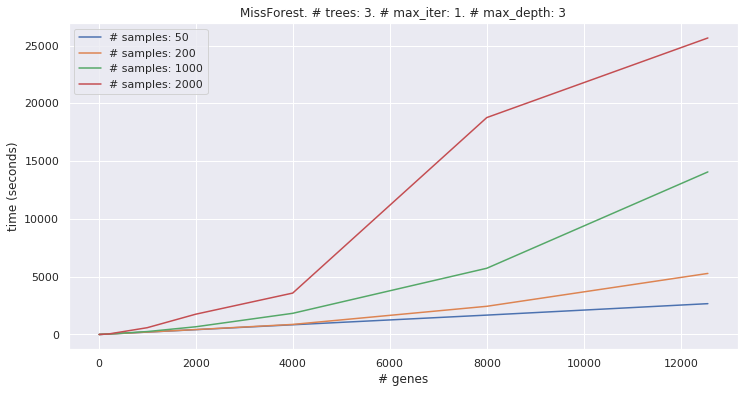

In [15]:
plt.figure(figsize=(12, 6))
plt.title('MissForest. # trees: {}. # max_iter: {}. # max_depth: {}'.format(n_estimators, max_iter, max_depth))
times_ = np.array(times).T
for i, t in enumerate(times_):
    plt.plot(g, times_[i], label="# samples: {}".format(s[i]))
    plt.legend()
    plt.xlabel('# genes');
    # plt.xscale('log')
    plt.ylabel('time (seconds)')
# plt.savefig('.pdf', bbox_inches='tight')